In [ ]:
#@title Installation of necessary liberies and solver
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install -q pyomo


%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
import pyomo.environ as pyo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00


# Flash Calculation Using Cubic Equation of State in an Equation Oriented Way
In this notebook, the problem related to flash calacuation and isolation of approperiate roots in cubic equations of state without causing discountinuity in flash problem formulation is addresed based on works done by Kamath et all and Dowling et all. Traditionally, when there is a possibilty of phase change, it is needed to check roots of cubic equations of state with logical conditions (if and else statements) to check whether there is a phase change or not. The purpose here is to relax equilibrium condition when we are out of two phase region( only liquid or vapor).
Using powerfull algebraic modeling language Pyomo and interior point solver Ipopt the stated problem is addressed.


<img src='https://www.pi-research.org/publication/e_001_schweidtmann-et-al-2019-escape/featured.jpg' alter='flash tank image'>


### Theoritical background
*   #### Solving flash problem
        
  The problem formualtion is written in the following:

  1. $\: n_f = n_l + n_v, $
  1. $\: n_f\:z_i = n_l\:x_i + n_v\:y_i,\quad i =1,...,n $
  1. $\: n_f\:h_f = n_l\:h_l + n_v\:h_v + Q,\quad i =1,...,n $
  1. $\: y_i = k_i (P, T, x) x_i,\quad i = 1,...,n $
  1. $\: \sum_{i=1}^{n} x_i - \sum_{i=1}^{n} y_i =0,\quad i =1,...,n $
  1. $\: \beta-1 = s_V - s_L,\quad i =1,...,n $
  1. $\: −s_L \leq \beta-1 \leq s_V,\quad i =1,...,n $
  1. $\: f(z_v)=0, $
  1. $\: f'(z_v)\geq 0 , $
  1. $\: f''(z_v)\geq-Ms_V , $
  1. $\: f(z_l)=0, $
  1. $\: f'(z_v)\geq 0 , $
  1. $\: f''(z_v)\leq Ms_L , $

  where $ k_i= \phi^l_i / \phi^v_i  \quad and \quad f(z) = z^3 + a_1z^2 + a_2z + a_3  $

  the objective function for optimization is:

  $ \rho(s_vn_v+s_ln_l) $




*   #### Equation of state

  $\: f(z)\: and \: \phi_i $ should be calculated using a cubic equation of state. Here Peng-Robinson method is selected for calcuation of $z_l \:and\: z_v$.
  To do this, there are some utility function written in accordance to Pyomo syntax to calculate mentioned quantities.


## Utility functions to calculate  $\: f(z)\: and \: \phi_i $

In [ ]:
def zfactor(a, b, z):
  # Calculate the coefficients of cubic equation of state.

  a1 = 1
  a2 = b - 1
  a3 = a - 2*b - 3*b**2
  a4 = -a*b + b**2 + b**3
  # Choose the real roots.
  f = a1*z**3 + a2*z**2 + a3*z + a4
  df = 3*a1*z**2 + 2*a2*z + a3
  d2f = 6*a1*z + 2*a2

  return (f,df,d2f)


def calcab_multicomp(press, temp, pressc, tempc, acentric):
  # calculate multicomponent mixture parameters

  ncomp = pressc.shape[0]
  m = []
  b = np.zeros((ncomp,1))
  omegaa = 0.45724
  omegab = 0.0778
  R = 8.314;

  for i in range(ncomp):
      # Calculate m.
      if acentric[i] > 0.49:
          m.append(0.379642 + 1.48503*acentric[i] - 0.164423*acentric[i]**2 + 0.016666*acentric[i]**3)
      else:
          m.append(0.37464 + 1.54226*acentric[i] - 0.26992*acentric[i]**2)

  # Calculate reduced pressure and temperature.
  pressr = (press/pressc)
  tempr = (temp/tempc)
  # Calculate alpha.
  alpha = [( 1 + m[i]*(1 - pyo.sqrt(temp)/pyo.sqrt(tempc[i])))**2 for i in range(ncomp)]

  A = [omegaa*alpha[i]*pressr[i]/tempr[i]**2 for i in range(ncomp)]
  B = [omegab*pressr[i]/tempr[i] for i in range(ncomp)]
  a = [omegaa*(R*(tempc[i]))**2/pressc[i]*alpha[i] for i in range(ncomp)]
  b = [omegab*R*tempc[i]/pressc[i] for i in range(ncomp)]

  da = [-m[i]*omegaa*(R*(tempc[i]))**2/pressc[i]*pyo.sqrt(alpha[i])/(pyo.sqrt((temp)*(tempc[i]))) for i in range(ncomp)]

  return (A, B, a, b, da)


def calcabmix(comp, A, B, BIP, a, b, da):

  ncomp = len(comp);
  # Calculate mixture parameters

  Aij = np.zeros((ncomp, ncomp))
  aij = np.zeros((ncomp, ncomp))
  damix = np.zeros((ncomp, ncomp))

  Amix = sum([comp[i]*comp[j]*pyo.sqrt(A[i]*A[j])*(1-BIP[i,j]) for i in range(ncomp) for j in range(ncomp)])
  amix = sum([comp[i]*comp[j]*pyo.sqrt(a[i]*a[j])*(1-BIP[i,j]) for i in range(ncomp) for j in range(ncomp)])
  dadT = sum([comp[i]*comp[j]*0.5/(pyo.sqrt(a[i]*a[j]))*(da[i]*a[j] + a[i]*da[j]) for i in range(ncomp) for j in range(ncomp)])

  bmix = sum([comp[i]*b[i] for i in range(ncomp)])
  Bmix = sum([comp[i]*B[i] for i in range(ncomp)])

  Amix2 = [sum([comp[j]*pyo.sqrt(A[i]*A[j])*(1-BIP[i,j]) for j in range(ncomp)]) for i in range(ncomp)]

  return (Amix, Bmix, Amix2, amix,bmix, dadT)

def calcfugcoef_multicomp(zfactor, A, B, Amix, Bmix, Amix2):
  # fugacity calculation using Peng-Robinson eos

  ncomp = 5
  c0 = 2*np.sqrt(2)
  c1 = 1 + np.sqrt(2)
  c2 = 1 - np.sqrt(2)

  fugcoef = [pyo.exp( B[i]/Bmix*(zfactor - 1) - pyo.log(zfactor - Bmix) \
                   - Amix/(c0*Bmix) * (2*Amix2[i]/Amix - B[i]/Bmix) \
                     *pyo.log((zfactor + c1*Bmix)/(zfactor + c2*Bmix)) ) \
           for i in range(ncomp)]

  return fugcoef


def h_ig_calc(comp, temp):
  # enthalpy calculation for an ideal gas mixture
  ncomp = len(comp)
  a = [0, 0, 0, 0, 0];
  b = np.array([2.94, 3.80, 3.47, 3.20,4.61])*10
  c = np.array([-1.09e-1, -3.73, -1.84, 2.13, 2.30])*10**-2
  d = np.array([1.94e-7, 1.01e-4, 1.57e-4, 1.67e-4, 2.23e-4])
  e = np.array([3.26e-9, -7.08e-8, -1.38e-7, -1.64e-7, -2.20e-7])
  f = np.array([-1.65e-12, 1.81e-11, 4.14e-11, 5.12e-11, 6.87e-11])

  h_ig_i = a + b*temp + c*temp**2 + d*temp**3 + e*temp**4 + f*temp**5
  hig = sum([comp[i]*h_ig_i[i] for i in range(ncomp)])

  return hig


def h_calc(comp, temp, zfactor, Amix, Bmix, amix, bmix, dadT):
  # enthalpy calculation for a real fluid

  R = 8.314
  c0 = 2*np.sqrt(2)
  c1 = 1 + np.sqrt(2)
  c2 = 1 - np.sqrt(2)

  h_res = R*temp*(zfactor-1)-1/(c0*bmix)*(amix - temp*dadT)*pyo.log((zfactor + c1*Bmix)/(zfactor + c2*Bmix))
  h = (h_ig_calc(comp ,temp) + h_res)/10000

  return h




## Defintion of the flash model within Pyomo
This function gives us a mathematical model that can be used in an appropriate solver

In [ ]:
def flash_calcualtion(feed, init_values, flash_spec, constants, mode='tp', rho=1000, M=1e3):
  # mathematical formulation for flash calculation
  z = feed['comp']; F = feed['F']
  press = feed['Pin']; h_feed = feed['hin']
  ncomp = len(z)
  pressc=constants['Pcs']; tempc=constants['Tcs'];
  acentric = constants['omegas']; BIP = constants['kijs']

  m = pyo.ConcreteModel()
  # variables
  m.i = pyo.RangeSet(0,ncomp-1)
  m.V = pyo.Var(initialize=init_values[0], domain=pyo.NonNegativeReals)
  m.s_l = pyo.Var(initialize=init_values[1], domain=pyo.NonNegativeReals)
  m.s_v = pyo.Var(initialize=init_values[2], domain=pyo.NonNegativeReals)
  m.beta = pyo.Var(initialize=init_values[3], domain=pyo.NonNegativeReals)
  m.z_l = pyo.Var(initialize=init_values[4], domain=pyo.NonNegativeReals)
  m.z_v = pyo.Var(initialize=init_values[5], domain=pyo.NonNegativeReals)
  m.x = pyo.Var(m.i, initialize=init_values[6], domain=pyo.NonNegativeReals, bounds=(0,1) )
  m.y = pyo.Var(m.i, initialize=init_values[7], domain=pyo.NonNegativeReals, bounds=(0,1))

  if mode.lower() == 'pq' or mode.lower() == 'qp':
    Q = flash_spec['Q']
    m.T = pyo.Var(initialize=flash_spec['T']/300, domain=pyo.NonNegativeReals,bounds=(1e-8, 1.5))
  elif mode.lower() == 'pt' or mode.lower() == 'tp':
    m.T = pyo.Param(initialize=flash_spec['T'])
    m.Q = pyo.Var(initialize=flash_spec['Q'])
  else:
    print("Select one of these two options \n mode='tp' --> TP flash \n mode='qp' --> QP flash")

  m.J = pyo.Objective(expr = rho*(m.V*m.s_v + (1-m.V)*m.s_l), sense=pyo.minimize)

  # expersion calculation based on current values
  if mode.lower() == 'pq' or mode.lower() == 'qp':
    (A, B, a, b, da) = calcab_multicomp(press, m.T*300, pressc, tempc, acentric)
    (Amix_l, Bmix_l, Amix2_l, amix_l, bmix_l, dadT_l) = calcabmix(m.x, A, B, BIP, a, b, da)
    (Amix_v, Bmix_v, Amix2_v, amix_v, bmix_v, dadT_v) = calcabmix(m.y, A, B, BIP, a, b, da)
    h_l = h_calc(m.x, m.T*300, m.z_l, Amix_l, Bmix_l, amix_l, bmix_l, dadT_l)
    h_v = h_calc(m.y, m.T*300, m.z_v, Amix_v, Bmix_v, amix_v, bmix_v, dadT_v)
    phi_l = calcfugcoef_multicomp(m.z_l, A, B, Amix_l, Bmix_l, Amix2_l)
    phi_v = calcfugcoef_multicomp(m.z_v, A, B, Amix_v, Bmix_v, Amix2_v)

  elif mode.lower() == 'pt' or mode.lower() == 'tp':
    (A, B, a, b, da) = calcab_multicomp(press, m.T, pressc, tempc, acentric)
    (Amix_l, Bmix_l, Amix2_l, amix_l, bmix_l, dadT_l) = calcabmix(m.x, A, B, BIP, a, b, da)
    (Amix_v, Bmix_v, Amix2_v, amix_v, bmix_v, dadT_v) = calcabmix(m.y, A, B, BIP, a, b, da)
    h_l = h_calc(m.x, m.T, m.z_l, Amix_l, Bmix_l, amix_l, bmix_l, dadT_l)
    h_v = h_calc(m.y, m.T, m.z_v, Amix_v, Bmix_v, amix_v, bmix_v, dadT_v)
    phi_l = calcfugcoef_multicomp(m.z_l, A, B, Amix_l, Bmix_l, Amix2_l)
    phi_v = calcfugcoef_multicomp(m.z_v, A, B, Amix_v, Bmix_v, Amix2_v)


  # equalities
  m.eq2 = pyo.Constraint(m.i, rule= lambda m,i: F*z[i] == (1-m.V)*m.x[i] + m.V*m.y[i])
  m.eq31 = pyo.Constraint(expr = sum([m.x[c] for c in m.i]) -1 == 0)
  m.eq32 = pyo.Constraint(expr = sum([m.x[c] for c in m.i]) -1 == 0)
  m.eq4 = pyo.Constraint(rule = lambda m,i: zfactor(Amix_l, Bmix_l, m.z_l)[0] == 0 )
  m.eq5 = pyo.Constraint(rule = lambda m,i: zfactor(Amix_v, Bmix_v, m.z_v)[0] == 0 )
  m.eq6 = pyo.Constraint(m.i, rule= lambda m,i: m.y[i] == m.beta*(phi_l[i]/phi_v[i])*m.x[i])
  if mode.lower() == 'pq' or mode.lower() == 'qp':
    m.eq7 = pyo.Constraint(rule = lambda m,i: F*h_feed == (1-m.V)*h_l + m.V*h_v - Q)
  elif mode.lower() == 'pt' or mode.lower() == 'tp':
    m.eq7 = pyo.Constraint(rule = lambda m,i: F*h_feed == (1-m.V)*h_l + m.V*h_v - m.Q)



  # inequalities
  m.ieq1 = pyo.Constraint(expr = -m.s_l <= m.beta-1)
  m.ieq2 = pyo.Constraint(expr = m.beta-1 <= m.s_v)
  m.ieq3 = pyo.Constraint(rule = lambda m,i: -M*m.s_v <= zfactor(Amix_v, Bmix_v, m.z_v)[2] )
  m.ieq4 = pyo.Constraint(rule = lambda m,i: M*m.s_l >= zfactor(Amix_l, Bmix_l, m.z_l)[2] )
  m.ieq5 = pyo.Constraint(rule = lambda m,i: 0 <= zfactor(Amix_v, Bmix_v, m.z_v)[1] )
  m.ieq6 = pyo.Constraint(rule = lambda m,i: 0 <= zfactor(Amix_l, Bmix_l, m.z_l)[1] )
  m.ieq7 = pyo.Constraint(expr = m.V <= F )

  return m


## Determination of flash problem inputs
In the following flash calculation for an example is shown to determine the effectivness of the solution. The feed stream to flash seprator is a mixture of nitrogen, methane, ethane, propane, n-butane. Some parameters and constants are needed in order to provide flash calcualtion with data related to components.These data belong to that are extrated from references.
Also, the flash problme need specification to calculate the properties of outlet vapor and liquid stream. Here, two modes are defined TP and QP flash. By inserting suitable specs and inputs to the flash calculation routine, it can provide solution to the problem effectively.  

In [ ]:
# a mixture of gas with related data

pressc = np.array([33.944, 46.407, 48.839, 42.567, 37.966])*1e5
tempc = np.array([126.194, 190.699, 305.428, 369.898, 425.199])
acentric = np.array([4.00e-2, 1.15e-2, 9.86e-2, 0.1524, 0.2010])
BIP = np.array([[0.0, 0.0289, 0.0533, 0.0878, 0.0711],
    [0.0289, 0.0, -0.0059, 0.0119, 0.0185],
    [0.0533, -0.0059, 0.0, 0.0011, 0.0089],
    [0.0878, 0.0119, 0.0011, 0.0, 0.0033],
    [0.0711, 0.0185, 0.0089, 0.0033, 0.0] ])

constants = {'Pcs': pressc, 'Tcs': tempc, 'omegas': acentric, 'kijs': BIP}
feed = {'comp':[0.025, 0.65, 0.15, 0.15 ,0.025], 'F':1, 'Tin':300, 'Pin':55e5,'hin':9.2225e3/10000}

# initial guess for optimization problem
V = 1;
s_l = 5.2879;
s_v = 0;
beta = 0.94;
z_l = 0.19;
z_v = 0.7414;
x = {0:0.0060, 1:0.2840, 2:0.1817, 3:0.3895 ,4: 0.1388}
y = {0:0.025, 1:0.65, 2:0.15, 3:0.15 ,4:0.025}
init_values = [V, s_l, s_v, beta, z_l, z_v, x, y]

flash_spec = {'Q':-6000/10000, 'T':260} # in the case of TP flash Q is used for an initial guess in the prblem and in the case of QP flash T is used for an initial guess

model = flash_calcualtion(feed, init_values, flash_spec, constants, mode='pq', rho=9e5, M=1e20)

In [ ]:
# designation of ipopt as the solver
solver = pyo.SolverFactory('ipopt')

# flash calculation
solver.solve(model)

# solution details
model.display()

Model unknown

  Variables:
    V : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :     0 : 0.5901058839176578 :  None : False : False : NonNegativeReals
    s_l : Size=1, Index=None
        Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
        None :     0 : 9.077189871454817e-12 :  None : False : False : NonNegativeReals
    s_v : Size=1, Index=None
        Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
        None :     0 : 8.404313961913697e-12 :  None : False : False : NonNegativeReals
    beta : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :     0 : 1.0000000000651201 :  None : False : False : NonNegativeReals
    z_l : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :     0 : 0.1752893509365845 :  None : False : False : NonNegativeReals
    z_v : Size=1

## Visualization
In order to see the robustness of the solver, the same initial guess is used and the problem is solved with a range of different values for Q in PQ flash calculation. The results is plotted here.  

In [ ]:
ncomp = len(feed['comp'])
# q_step = [0, -400.0, -435.0, -3000.0, -6000.0, -10500, -10800, -11000]
q_step = np.linspace(0,-11000,35)
solutions = []

for q in q_step:
  flash_spec = {'Q':q/10000, 'T':300}
  model = flash_calcualtion(feed, init_values, flash_spec, constants, mode='pq', rho=9e5, M=1e20)
  solver.solve(model)
  solution = {}
  solution['solver_convergence'] = pyo.value(model.J)
  solution['T'] = pyo.value(model.T*300)
  solution['V'] = pyo.value(model.V)
  solution['x'] = [pyo.value(model.x[i]) for i in range(ncomp)]
  solution['y'] = [pyo.value(model.y[i]) for i in range(ncomp)]
  solutions.append(solution)



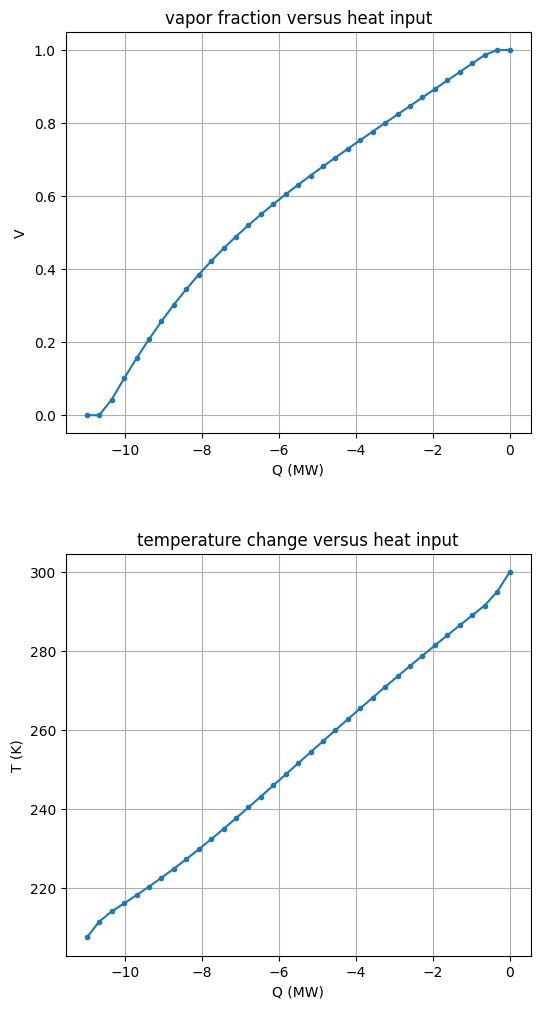

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 12))

plt.subplots_adjust(wspace=0.5, hspace=0.3)

ax[0].plot(q_step/1000,[sol['V'] for sol in solutions],'.-')
ax[0].grid(True); ax[0].set_xlabel('Q (MW)'); ax[0].set_ylabel('V');ax[0].set_title('vapor fraction versus heat input');
ax[1].plot(q_step/1000,[sol['T'] for sol in solutions],'.-')
ax[1].grid(True); ax[1].set_xlabel('Q (MW)'); ax[1].set_ylabel('T (K)'); ax[1].set_title('temperature change versus heat input');